In [15]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import pennylane as qml
from pennylane import numpy as npqml

# Ensure consistent path handling
PROJ_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
DATA_DIR = os.path.join(PROJ_ROOT, "Datasets", "Processed")
RESULTS_DIR = os.path.join(PROJ_ROOT, "Results")

# Ensure results directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

In [16]:
processed_csv = os.path.join(DATA_DIR, "gaia_features_20.csv")
if not os.path.exists(processed_csv):
    raise FileNotFoundError(f"{processed_csv} not found. Run gaia_feature_selection.py first.")

df = pd.read_csv(processed_csv)
print("Loaded dataset shape:", df.shape)

# Features and labels
X = df.drop(columns=["label"]).values
y = df["label"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to Torch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

Loaded dataset shape: (20000, 21)


In [17]:
n_qubits = 4  # can increase depending on feature encoding
n_layers = 2

dev = qml.device("default.qubit", wires=n_qubits)

def angle_embedding(x, wires):
    """Encode features into qubit rotations (truncating/padding as needed)."""
    x = np.array(x)  # Use regular numpy instead of npqml
    # Truncate or pad features to match n_qubits
    if len(x) < len(wires):
        x = np.pad(x, (0, len(wires) - len(x)))
    elif len(x) > len(wires):
        x = x[:len(wires)]
    for i, wire in enumerate(wires):
        qml.RY(x[i], wires=wire)

@qml.qnode(dev, interface="torch")
def circuit(inputs, weights):
    angle_embedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [20]:
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

class VQCClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qlayer
        self.fc = nn.Linear(n_qubits, 2)  # 2 classes: nearby vs distant

    def forward(self, x):
        x = self.qlayer(x)
        return self.fc(x)

model = VQCClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [21]:
n_epochs = 50
for epoch in range(n_epochs):
    optimizer.zero_grad()
    # Only use the first n_qubits features for training
    batch = X_train_t[:, :n_qubits]
    # Apply model to each sample individually and stack results
    outputs = torch.stack([model(x) for x in batch])
    loss = loss_fn(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

KeyboardInterrupt: 


Test Accuracy: 0.9900
Confusion Matrix:
[[99  1]
 [ 0  0]]


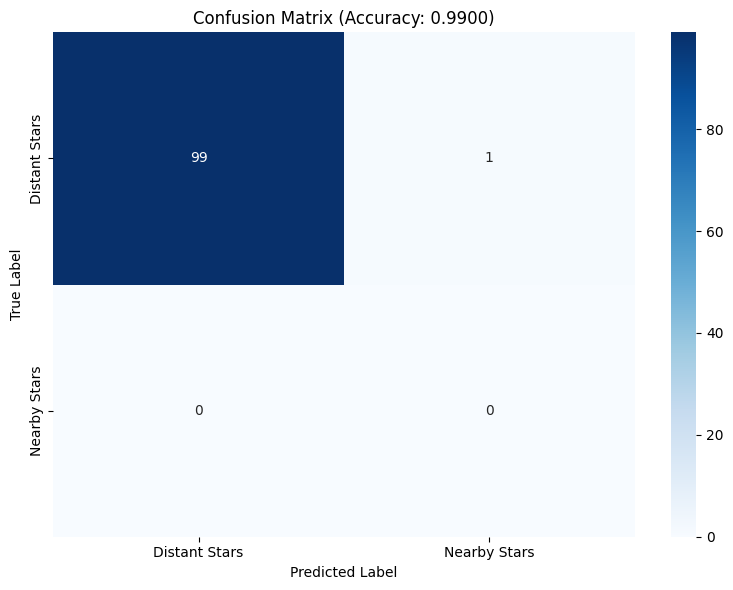

In [ ]:
with torch.no_grad():
    # Only use the first n_qubits features and process each sample individually
    batch = X_test_t[:, :n_qubits]
    outputs = torch.stack([model(x) for x in batch])
    y_pred = torch.argmax(outputs, dim=1).numpy()

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix with a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Distant Stars', 'Nearby Stars'],
            yticklabels=['Distant Stars', 'Nearby Stars'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Accuracy: {acc:.4f})')
plt.tight_layout()
plt.show()

In [ ]:
# Save predictions
pred_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})
pred_df.to_csv(os.path.join(RESULTS_DIR, "vqc_predictions.csv"), index=False)
print(f"Predictions saved to {os.path.join(RESULTS_DIR, 'vqc_predictions.csv')}")

# Save model weights
torch.save(model.state_dict(), os.path.join(RESULTS_DIR, "vqc_model.pt"))
print(f"Model weights saved to {os.path.join(RESULTS_DIR, 'vqc_model.pt')}")

Predictions saved to Results/vqc_predictions.csv
Model weights saved to Results/vqc_model.pt


In [ ]:
try:
    import torchviz
    # Visualize the model architecture
    x_sample = X_test_t[0, :n_qubits].unsqueeze(0)
    torchviz.make_dot(model(x_sample), params=dict(model.named_parameters())).render("vqc_model_architecture", format="png")
    print("Model architecture visualized and saved as vqc_model_architecture.png")
except ImportError:
    print("torchviz package not available. Skipping model visualization.")
    
# Evaluate the model on the test set
with torch.no_grad():
    # Only use the first n_qubits features and process each sample individually
    batch = X_test_t[:, :n_qubits]
    outputs = torch.stack([model(x) for x in batch])
    y_pred = torch.argmax(outputs, dim=1).numpy()

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(cm)

torchviz package not available. Skipping model visualization.
Test Accuracy: 0.9900
Confusion Matrix:
[[99  1]
 [ 0  0]]
Test Accuracy: 0.9900
Confusion Matrix:
[[99  1]
 [ 0  0]]
